In [2]:
from datasets.shapenet_part import PartNormalDataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from datasets.shapenet_data_pc import ShapeNet15kPointClouds

from metrics.ChamferDistancePytorch.chamfer_python import distChamfer

from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud
from models_adl4cv.pvcnn import PVCNNPartSeg, PVCNN

In [3]:
tr_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir="./ShapeNetCore.v2.PC15k",
    categories=["chair"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

Total number of data:4612
Min number of points: (train)2048 (test)2048
Total number of data:662
Min number of points: (train)2048 (test)2048
Total number of data:1317
Min number of points: (train)2048 (test)2048


In [4]:
len(tr_dataset), len(val_dataset), len(test_dataset)

(4612, 662, 1317)

In [5]:
train_dataloader = torch.utils.data.DataLoader(tr_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

In [6]:
def add_random_noise(point_cloud, mean=0, std=0.025):
    noise = torch.normal(mean, std, size=point_cloud.size()).to("cuda")
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [7]:
def chamfer_distance(a, b):
    min_dist_a_to_b, min_dist_b_to_a, _, _ = distChamfer(a, b)
    return (min_dist_a_to_b.mean() + min_dist_b_to_a.mean()) / 2

In [80]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=4).to("cuda")

In [9]:
part_model = PVCNNPartSeg(num_classes=4, num_shapes=3, extra_feature_channels=0).to("cuda")
part_model.load_state_dict(torch.load("output-models/pvcnn-part-segmentation-noise-chair/PVCNN-Part-Segmentation-Noise-Chair-e48.pth"))

<All keys matched successfully>

In [84]:
# TensorBoard Logging with model's name and current date
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PVCNN-Refinement-Part-Class-Condition-Chair-Residuals-0.05std'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

# Optimization
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.998)

# Losses
training_losses = []
val_losses = []

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

In [85]:
# Time to train
for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in train_dataloader:
        input = batch["train_points"].to("cuda")
        
        noised_input = add_random_noise(input, std=0.05)
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1] # .unsqueeze(-1)

        optimizer.zero_grad()
        
        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((noised_input, class_labels_one_hot), dim=-1)

        output = model(combined_tensor.transpose(1,2)).transpose(1,2)

        loss = chamfer_distance(input, noised_input - output)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    # Epoch is done; Reduce LR
    lr_scheduler.step()

    # Validate
    model.eval()
    with torch.no_grad():
        for batch in val_dataloader:
            input = batch["train_points"].to("cuda")
            
            # Let's first add noise
            noised_input = add_random_noise(input, std=0.05)

            # Let's segment the input into parts and extract the part assignment.
            input_seg = part_model(noised_input.transpose(1,2)).transpose(1,2).data.max(2)[1] # .unsqueeze(-1)
            
            # Classes in one extra feature
            # classes_input = torch.cat([noised_input, input_seg], dim=2)
            # output = model(classes_input.transpose(1,2)).transpose(1,2)

            # Normal
            # output = model(noised_input.transpose(1,2)).transpose(1,2)

            # One hot encoded
            class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
            combined_tensor = torch.cat((noised_input, class_labels_one_hot), dim=-1)
            output = model(combined_tensor.transpose(1,2)).transpose(1,2)

            val_loss = chamfer_distance(input, noised_input - output)
            total_val_loss += val_loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

    # Check for improvement
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0  # reset the patience counter
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break

    # Save the model
    model_save_path = f"output-models/pvcnn-refinement-part-class-chair/PVCNN-Baseline-Refinement-Part-Class-Chair-Residuals-0.05-Noise-e{epoch+1}.pth"
    torch.save(model.state_dict(), model_save_path)


writer.close()

Epoch 1,  Training Loss: 0.0036, Validation Loss: 0.0035
Epoch 2,  Training Loss: 0.0036, Validation Loss: 0.0035
Epoch 3,  Training Loss: 0.0035, Validation Loss: 0.0035
Epoch 4,  Training Loss: 0.0035, Validation Loss: 0.0035
Epoch 5,  Training Loss: 0.0035, Validation Loss: 0.0035
Epoch 6,  Training Loss: 0.0035, Validation Loss: 0.0035
Epoch 7,  Training Loss: 0.0035, Validation Loss: 0.0035
No improvement in validation loss for 1 epochs.
Epoch 8,  Training Loss: 0.0035, Validation Loss: 0.0034
Epoch 9,  Training Loss: 0.0035, Validation Loss: 0.0034
Epoch 10,  Training Loss: 0.0035, Validation Loss: 0.0034
No improvement in validation loss for 1 epochs.


KeyboardInterrupt: 

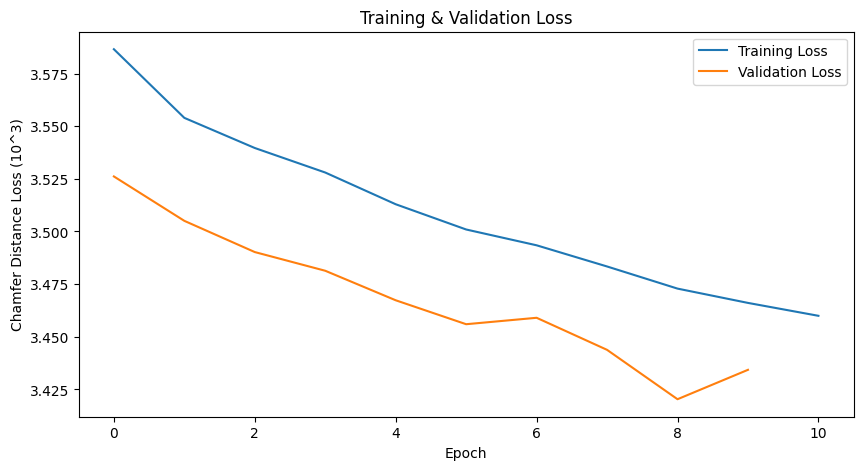

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(np.array(training_losses) * (10**3), label='Training Loss')
plt.plot(np.array(val_losses) * (10**3), label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss (10^3)')
plt.legend()
plt.show()

In [87]:
print(f"Best Train Loss: Epoch: {np.argmin(training_losses)}, Loss: {np.min(training_losses)* (10**3):.4f}")
print(f"Best Val Loss: Epoch: {np.argmin(val_losses)}, Loss: {np.min(val_losses) * (10**3):.4f}")

Best Train Loss: Epoch: 10, Loss: 3.4600
Best Val Loss: Epoch: 8, Loss: 3.4204


In [88]:
model = PVCNN(num_classes=3, num_shapes=3, extra_feature_channels=4).to("cuda")
model.load_state_dict(torch.load(f"output-models/pvcnn-refinement-part-class-chair/PVCNN-Baseline-Refinement-Part-Class-Chair-Residuals-0.05-Noise-e{np.argmax(val_losses)+1}.pth"))

# model.load_state_dict(torch.load("output-models/pvcnn-refinement-part-class-chair/PVCNN-Baseline-Refinement-Part-Class-Chair-Residuals-e24.pth"))

<All keys matched successfully>

In [89]:
# Test
total_test_loss = 0
batch_i=1

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input = batch["test_points"].to("cuda")
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]

        noised_input = add_random_noise(input, std=0.05)

        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((noised_input, class_labels_one_hot), dim=-1)
        output = model(combined_tensor.transpose(1,2)).transpose(1,2)
        
        test_loss = chamfer_distance(input, noised_input - output)
        total_test_loss += test_loss.item()
        print(f"Batch: {batch_i}; CD Loss: {test_loss.item() * 10**3:.4f}")
        batch_i+=1

avg_total_loss = total_test_loss / len(test_dataloader)
print(f"Test Loss: {avg_total_loss * 10**3:.4f}")

Batch: 1; CD Loss: 3.5730
Batch: 2; CD Loss: 3.3431
Batch: 3; CD Loss: 3.4937
Batch: 4; CD Loss: 3.4053
Batch: 5; CD Loss: 3.6246
Batch: 6; CD Loss: 3.7689
Batch: 7; CD Loss: 3.8587
Batch: 8; CD Loss: 3.5432
Batch: 9; CD Loss: 3.6030
Batch: 10; CD Loss: 3.6673
Batch: 11; CD Loss: 3.4541
Batch: 12; CD Loss: 3.1531
Batch: 13; CD Loss: 3.5587
Batch: 14; CD Loss: 3.4290
Batch: 15; CD Loss: 3.5888
Batch: 16; CD Loss: 3.5257
Batch: 17; CD Loss: 3.4946
Batch: 18; CD Loss: 3.5831
Batch: 19; CD Loss: 3.7372
Batch: 20; CD Loss: 3.3758
Batch: 21; CD Loss: 3.5205
Batch: 22; CD Loss: 3.9784
Batch: 23; CD Loss: 3.7139
Batch: 24; CD Loss: 3.6295
Batch: 25; CD Loss: 3.2768
Batch: 26; CD Loss: 3.7149
Batch: 27; CD Loss: 3.6278
Batch: 28; CD Loss: 3.2852
Batch: 29; CD Loss: 3.4756
Batch: 30; CD Loss: 3.4235
Batch: 31; CD Loss: 3.6152
Batch: 32; CD Loss: 3.5569
Batch: 33; CD Loss: 3.5319
Batch: 34; CD Loss: 3.4167
Batch: 35; CD Loss: 3.5177
Batch: 36; CD Loss: 3.8083
Batch: 37; CD Loss: 3.5306
Batch: 38;

In [90]:
INDEX = 15
input_pc = input[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
input_pc.shape, output_pc.shape

(torch.Size([2048, 3]), torch.Size([2048, 3]))

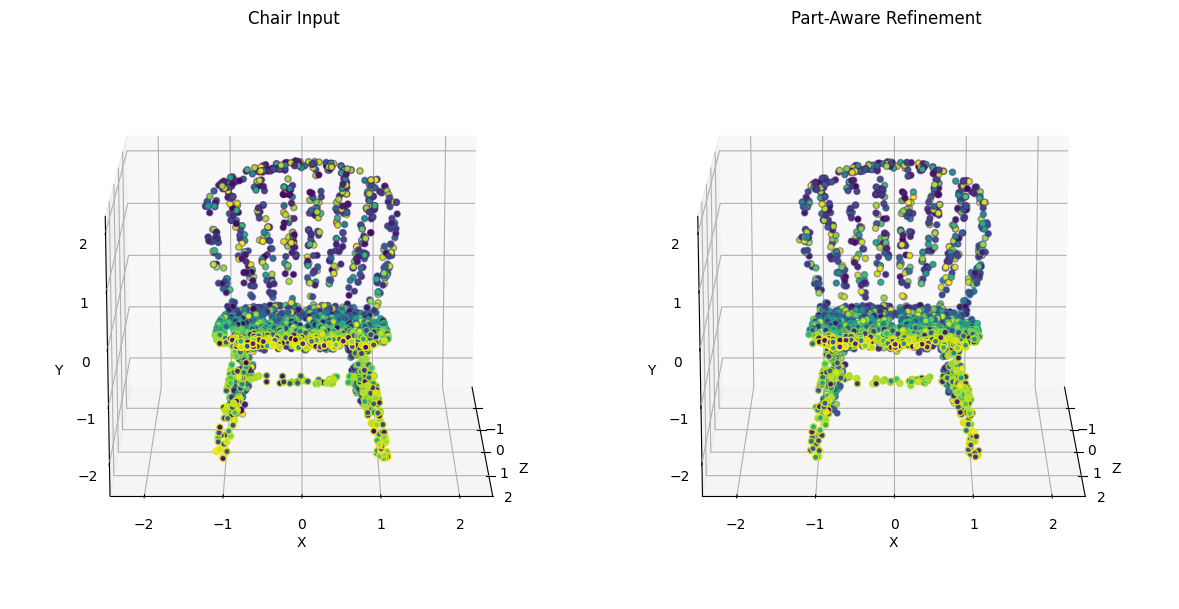

In [91]:
fig = visualize_pointcloud_eval(input_pc, input_pc - output_pc, "Chair Input", "Part-Aware Refinement")

In [92]:
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["chair"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd, 
                                               batch_size=20, 
                                               sampler=None, 
                                               shuffle=True is None, 
                                               num_workers=1, 
                                               drop_last=True)

Total number of data:400
Min number of points: (train)2048 (test)2048


In [93]:
input_array = []

for batch in val_dataloader:
    input = batch["test_points"].to("cuda")
    input_array.append(input)

In [94]:
# Evaluation
output_array = []

model.eval()
with torch.no_grad():
    for batch in dataloader_pvd:
        input = batch["test_points"].to("cuda")
        
        # Let's segment the input into parts and extract the part assignment.
        input_seg = part_model(input.transpose(1,2)).transpose(1,2).data.max(2)[1]
        
        # Classes in one extra feature
        # classes_input = torch.cat([noised_input, input_seg], dim=2)
        # output = model(classes_input.transpose(1,2)).transpose(1,2)

        # Normal
        # output = model(noised_input.transpose(1,2)).transpose(1,2)

        # One hot encoded
        class_labels_one_hot = F.one_hot(input_seg, num_classes=4)
        combined_tensor = torch.cat((input, class_labels_one_hot), dim=-1)
        output = model(combined_tensor.transpose(1,2)).transpose(1,2)
        output_array.append(input - output)
        

In [115]:
INDEX = 2
input_pc = input[INDEX, ...].detach()
output_pc = output[INDEX, ...].detach()
input_pc.shape, output_pc.shape

(torch.Size([2048, 3]), torch.Size([2048, 3]))

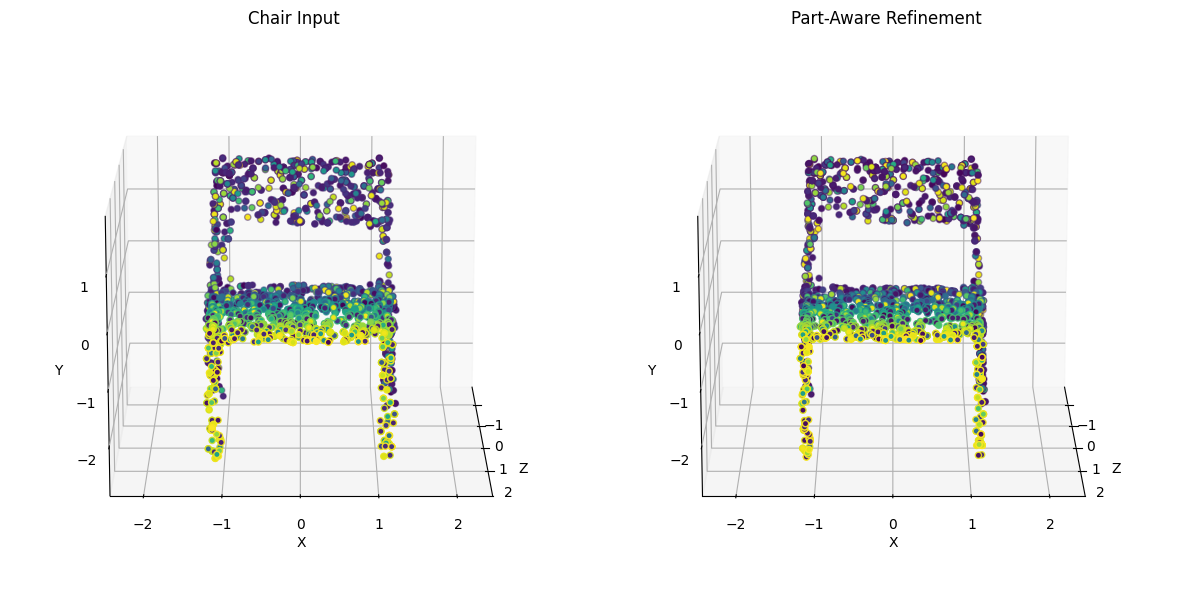

In [116]:
fig = visualize_pointcloud_eval(input_pc, input_pc - output_pc, "Chair Input", "Part-Aware Refinement")

In [105]:
len(input_array), len(output_array)

(33, 20)

In [106]:
input_pcs = torch.stack(input_array[:20]).view(400, 2048, 3)
output_pcs = torch.stack(output_array).view(400, 2048, 3)
input_pcs.shape, output_pcs.shape

(torch.Size([400, 2048, 3]), torch.Size([400, 2048, 3]))

In [110]:
from metrics.evaluation_metrics import compute_all_metrics

results = compute_all_metrics(input_pcs, output_pcs, 100)
results = {k: (v.cpu().detach().item()
                if not isinstance(v, float) else v) for k, v in results.items()}

print(results)

100%|██████████| 400/400 [03:43<00:00,  1.79it/s]

{'lgan_mmd-CD': 0.09437601268291473, 'lgan_cov-CD': 0.5274999737739563, 'lgan_mmd_smp-CD': 0.10882489383220673, 'lgan_mmd-EMD': 0.559457540512085, 'lgan_cov-EMD': 0.5274999737739563, 'lgan_mmd_smp-EMD': 0.6051084399223328, '1-NN-CD-acc_t': 0.574999988079071, '1-NN-CD-acc_f': 0.5849999785423279, '1-NN-CD-acc': 0.5799999833106995, '1-NN-EMD-acc_t': 0.5824999809265137, '1-NN-EMD-acc_f': 0.5550000071525574, '1-NN-EMD-acc': 0.5687500238418579}


In [ ]:
result_0_025 = {
    "lgan_mmd-CD": 0.09321583062410355,
    "lgan_cov-CD": 0.5299999713897705,
    "lgan_mmd_smp-CD": 0.10687082260847092,
    "lgan_mmd-EMD": 0.5559535026550293,
    "lgan_cov-EMD": 0.5350000262260437,
    "lgan_mmd_smp-EMD": 0.6062434911727905,
    "1-NN-CD-acc_t": 0.6100000143051147,
    "1-NN-CD-acc_f": 0.5400000214576721,
    "1-NN-CD-acc": 0.574999988079071,
    "1-NN-EMD-acc_t": 0.5425000190734863,
    "1-NN-EMD-acc_f": 0.574999988079071,
    "1-NN-EMD-acc": 0.5587499737739563,
}
# 1-NNA-CD: 57.5%
# 1-NNA-EMD: 55.8%

result_0_05 = {
    {
        "lgan_mmd-CD": 0.09437601268291473,
        "lgan_cov-CD": 0.5274999737739563,
        "lgan_mmd_smp-CD": 0.10882489383220673,
        "lgan_mmd-EMD": 0.559457540512085,
        "lgan_cov-EMD": 0.5274999737739563,
        "lgan_mmd_smp-EMD": 0.6051084399223328,
        "1-NN-CD-acc_t": 0.574999988079071,
        "1-NN-CD-acc_f": 0.5849999785423279,
        "1-NN-CD-acc": 0.5799999833106995,
        "1-NN-EMD-acc_t": 0.5824999809265137,
        "1-NN-EMD-acc_f": 0.5550000071525574,
        "1-NN-EMD-acc": 0.5687500238418579,
    }
}

# 1-NNA-CD: 58%
# 1-NNA-EMD: 56.87%

In [117]:
output_pc.mean(), output_pc.std()

(tensor(-0.0004, device='cuda:0'), tensor(0.0237, device='cuda:0'))

Center: [-0.01265758 -0.43036163 -0.56554496], Scale: 4.687018394470215
Center: [-0.016397  -0.41608   -0.5790501], Scale: 4.6410441398620605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


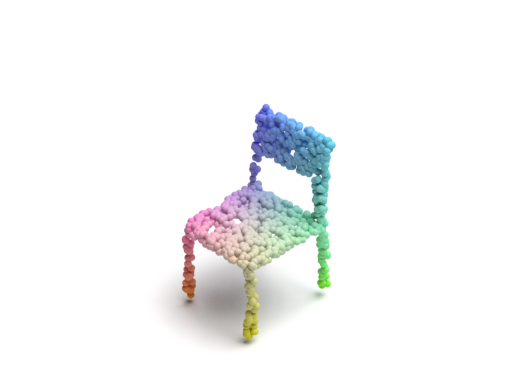

In [118]:
from visuals.mitsuba_vis import render_mitsuba

pvd_input_chair = render_mitsuba(input_pc.cpu().numpy(), "./PVD-Input-Chair.xml", fov=20)
refined_output_chair = render_mitsuba((input_pc - output_pc).cpu().numpy(), "./Refined-Output-Chair.xml", fov=20)

plt.axis("off")
plt.imshow(pvd_input_chair ** (1.0 / 2.2)); # approximate sRGB tonemapping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


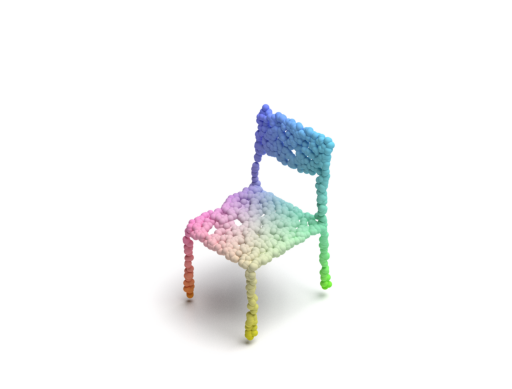

In [119]:
plt.axis("off")
plt.imshow(refined_output_chair ** (1.0 / 2.2)); # approximate sRGB tonemapping